# 評価方法

分類されていないデータを認識し、どれだけ正しくカテゴリごとに分類できるかを算出した「平均精度」の高さを競い合います。

今回、活用するデータはLSWMD_25519となります。
LSWMD_25519のFailureType項目が分類されていない状態のデータに対し、正しいFailureTypeカテゴリを分類するプログラムを作成し、その平均精度を算出します。
平均精度とは、カテゴリごとに正しく分類できる精度を平均した値です。カテゴリごとに算出した精度（Aが正しく分類された数/Aのデータ数）を足し、カテゴリ数で割ります。

公平な評価を実施するために、以下の制限を設けています。
1. 外部パッケージをインストールするためのセルとsolution関数の中身のみを編集すること
2. 校舎のiMac上で最後のセルの実行時間が15分未満であること　（%%timeitの出力結果を確認してください）

※気になる点がある場合、Discordで気軽にお問合せください。

In [1]:
import numpy as np # https://numpy.org/ja/
import pandas as pd # https://pandas.pydata.org/
from sklearn.model_selection import train_test_split

外部パッケージを使用する場合、以下の方法でインストールを実施してください。

In [2]:
# 必要な外部パッケージは、以下の内容を編集しインストールしてください
# !pip install keras
# !pip install tensorflow[and-cuda]
!pip install tensorflow
!pip install Pillow
!pip install matplotlib
!pip install scikit-image

以下のsolution関数のみ編集してください。

In [3]:
def show_img(image):
    import matplotlib.pyplot as plt

    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

def solution_random(x_test_df, train_df):
    # こちらの関数の中身を編集してください。
    import random
    from skimage.transform import radon

    waferMaps = train_df['waferMap']
    show_img(waferMaps[0])
    show_img(radon(waferMaps[0], theta=[0,90]))
    
    failure_types = list(train_df['failureType'].unique())
    num_rows = len(x_test_df)
    while len(failure_types) < num_rows:
        failure_types.append(random.choice(failure_types))

    return pd.DataFrame({'failureType': failure_types}, index=x_test_df.index)

In [4]:
def mirroring_map(map):
    # マップの次元を取得
    len_y, len_x = map.shape

    # マップの中心y座標とx座標を取得
    y_add = len_y // 2 + len_y % 2
    x_add = len_x // 2 + len_x % 2

    # 0の値のインデックスを取得
    y_indices, x_indices = np.where(map == 0)
    nwe_map = map.copy()
    # 他の位置に置換
    nwe_map[y_indices, x_indices] = map[(y_indices + y_add) % len_y, (x_indices + x_add) % len_x]
    # 0の値のインデックスを取得
    y_indices, x_indices = np.where(nwe_map == 0)
    # 0の値を置換
    nwe_map[y_indices, x_indices] = 1
    return nwe_map - 1.0

def mirroring_map2(map):
    # マップの次元を取得
    len_y, len_x = map.shape

    # マップの中心y座標とx座標を取得
    y_add = len_y // 2 + len_y % 2
    x_add = len_x // 2 + len_x % 2

    # 0の値のインデックスを取得
    y_indices, x_indices = np.where(np.full((len_y, len_x), True))
    nwe_map = np.empty((len_y, len_x))
    nwe_map[y_indices, x_indices] = map[(y_indices + y_add) % len_y, (x_indices + x_add) % len_x]
    # 他の位置に置換
    y_indices, x_indices = np.where(nwe_map == 0)
    nwe_map[y_indices, x_indices] = map[y_indices, x_indices]
    # 0の値のインデックスを取得
    y_indices, x_indices = np.where(nwe_map == 0)
    # 0の値を置換
    nwe_map[y_indices, x_indices] = 1
    return nwe_map - 1.0

def padding_map(map):
    nwe_map = map.copy() 
    # 0の値のインデックスを取得
    y_indices, x_indices = np.where(map == 1)
    # 他の位置に置換
    nwe_map[y_indices, x_indices] = 0
    return nwe_map

def radon_normalize(map, theta=[0,90,45,135], resize_shape=(256, 256)):
    from skimage.transform import radon
    from PIL import Image
    import numpy as np

    resize_map = np.array(Image.fromarray(map).resize(resize_shape, Image.LANCZOS))
    return radon(resize_map, theta=theta)

def preprocess_radon(wafer_map):
    data = np.rot90(np.array([radon_normalize(padding_map(x)) for x in wafer_map]), k=1, axes=(1, 2))
    print(data.shape)
    data = np.concatenate((data[::,0:2], data[::,2:4]), axis=0)
    print(data.shape)
    # 1. x軸の逆転
    buff = np.array([[x[0][::-1],x[1]] for x in data])
    data = np.concatenate((data, buff), axis=0)
    # 2. y軸の逆転
    buff = np.array([[x[0],x[1][::-1]] for x in data])
    data = np.concatenate((data, buff), axis=0)
    # 3. xy軸の逆転
    buff = np.array([[x[1],x[0]] for x in data])
    data = np.concatenate((data, buff), axis=0)
    return data


def preprocess_map(wafer_map):
    from PIL import Image

    # データの正規化
    train_maps = np.array([np.array(Image.fromarray(mirroring_map(x)).resize((32, 32), Image.LANCZOS)) for x in wafer_map])

    # 1. 画像を水平方向に反転
    flipped_horizontally = np.flip(train_maps, axis=2)
    train_maps = np.concatenate((train_maps, flipped_horizontally), axis=0)

    # 2. 画像を180度回転
    rotated_180 = np.rot90(train_maps, k=2, axes=(1, 2))
    train_maps = np.concatenate((train_maps, rotated_180), axis=0)

    # 3. 画像を90度回転
    rotated_90 = np.rot90(train_maps, k=1, axes=(1, 2))
    train_maps = np.concatenate((train_maps, rotated_90), axis=0)

    # データの形状を変更
    train_maps = train_maps.reshape(train_maps.shape + (1,))

    return train_maps

def preprocess_map2(wafer_map):
    from PIL import Image

    # データの正規化
    train_maps = np.array([np.array(Image.fromarray(mirroring_map2(x)).resize((32, 32), Image.LANCZOS)) for x in wafer_map])

    # 1. 画像を水平方向に反転
    flipped_horizontally = np.flip(train_maps, axis=2)
    train_maps = np.concatenate((train_maps, flipped_horizontally), axis=0)

    # 2. 画像を180度回転
    rotated_180 = np.rot90(train_maps, k=2, axes=(1, 2))
    train_maps = np.concatenate((train_maps, rotated_180), axis=0)

    # 3. 画像を90度回転
    rotated_90 = np.rot90(train_maps, k=1, axes=(1, 2))
    train_maps = np.concatenate((train_maps, rotated_90), axis=0)

    # データの形状を変更
    train_maps = train_maps.reshape(train_maps.shape + (1,))

    return train_maps

def cnn_model(input_shape, num_classes):
    import tensorflow as tf

    model = tf.keras.models.Sequential([
        # 畳み込みブロック1
        tf.keras.layers.Conv2D(24, 3, activation='relu', padding='same', input_shape=(input_shape)),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        
        # 畳み込みブロック2
        tf.keras.layers.Conv2D(24, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        
        # 畳み込みブロック3
        tf.keras.layers.Conv2D(24, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        
        # ブロック4
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(16, activation=tf.nn.relu),

        # 出力層
        tf.keras.layers.Dense(num_classes),
    ])

    return model

def dl_model(input_shape, num_classes):
    import tensorflow as tf

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(256, activation=tf.nn.relu),        
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(32, activation=tf.nn.relu),
        tf.keras.layers.Dense(num_classes),
    ])

    return model

def symple_model(input_shape, num_classes):
    import tensorflow as tf

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(12, activation=tf.nn.relu),
        tf.keras.layers.Dense(num_classes),
    ])
    return model

def symple_model2(input_shape, num_classes):
    import tensorflow as tf

    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(9, activation=tf.nn.relu),
        tf.keras.layers.Dense(num_classes),
    ])
    return model

def solution(x_test_df, train_df):
    import tensorflow as tf
    failure_types = list(train_df['failureType'].unique())

    train_L1_df, train_L2_df = train_test_split(train_df, stratify=train_df['failureType'], test_size=0.20, random_state=0)

    # 前処理
    test_maps1 = preprocess_map(x_test_df['waferMap'])
    train_L1_maps1 = preprocess_map(train_L1_df['waferMap'])
    train_L2_maps1 = preprocess_map(train_L2_df['waferMap'])

    test_maps2 = preprocess_map2(x_test_df['waferMap'])
    train_L1_maps2 = preprocess_map2(train_L1_df['waferMap'])
    train_L2_maps2 = preprocess_map2(train_L2_df['waferMap'])

    train_labels_L1 = np.array([failure_types.index(x) for x in train_L1_df['failureType']] * 8)
    train_labels_L2 = np.array([failure_types.index(x) for x in train_L2_df['failureType']] * 8)


    # モデルの作成
    model_L1_cnn1 = cnn_model(train_L1_maps1[0].shape, len(failure_types))
    model_L1_cnn1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model_L1_cnn2 = cnn_model(train_L1_maps2[0].shape, len(failure_types))
    model_L1_cnn2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model_L2 = symple_model((2,len(failure_types)), len(failure_types))
    model_L2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

    #学習
    model_L1_cnn1.fit(train_L1_maps1, train_labels_L1, epochs=7)
    model_L1_cnn2.fit(train_L1_maps2, train_labels_L1, epochs=7)

    logits_L1_cnn1 = model_L1_cnn1.predict(train_L2_maps1)
    logits_L1_cnn2 = model_L1_cnn2.predict(train_L2_maps2)
    train_L2 = np.array([ [cnn, dl] for cnn, dl in zip(tf.nn.softmax(logits_L1_cnn1).numpy(), tf.nn.softmax(logits_L1_cnn2).numpy())])
    model_L2.fit(train_L2, train_labels_L2, epochs=12)
    
    test_len = len(x_test_df['waferMap'])
    # 予測
    logits_cnn1 = model_L1_cnn1.predict(test_maps1)
    logits_cnn2 = model_L1_cnn2.predict(test_maps2)
    test_pre = np.array([ [cnn, dl] for cnn, dl in zip(tf.nn.softmax(logits_cnn1).numpy(), tf.nn.softmax(logits_cnn2).numpy())])
    logits = model_L2.predict(test_pre)
    test_logits = np.zeros(test_len * len(failure_types), dtype=np.float64).reshape((test_len,len(failure_types)))
    for n in range(8):
        test_logits += logits[test_len*n:test_len*(n + 1)] / 8
    predictions = tf.nn.softmax(test_logits).numpy()
    answer = [failure_types[x.argmax()] for x in predictions]

    return pd.DataFrame({'failureType': answer}, index=x_test_df.index)

solution関数は以下のように活用され、平均精度を計算します。

2023-12-06 07:08:56.152187: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 602046464 exceeds 10% of free system memory.


Epoch 1/6
4594/4594 [==============================] - 31s 7ms/step - loss: 0.3084 - accuracy: 0.8836
Epoch 2/6
4594/4594 [==============================] - 26s 6ms/step - loss: 0.1808 - accuracy: 0.9313
Epoch 3/6
4594/4594 [==============================] - 26s 6ms/step - loss: 0.1507 - accuracy: 0.9432
Epoch 4/6
4594/4594 [==============================] - 26s 6ms/step - loss: 0.1343 - accuracy: 0.9478
Epoch 5/6
4594/4594 [==============================] - 27s 6ms/step - loss: 0.1227 - accuracy: 0.9531
Epoch 6/6
4594/4594 [==============================] - 26s 6ms/step - loss: 0.1133 - accuracy: 0.9556


2023-12-06 07:11:47.923512: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 602046464 exceeds 10% of free system memory.


Epoch 1/6
4594/4594 [==============================] - 29s 6ms/step - loss: 0.3352 - accuracy: 0.8756
Epoch 2/6
4594/4594 [==============================] - 27s 6ms/step - loss: 0.2067 - accuracy: 0.9222
Epoch 3/6
4594/4594 [==============================] - 26s 6ms/step - loss: 0.1732 - accuracy: 0.9347
Epoch 4/6
4594/4594 [==============================] - 26s 6ms/step - loss: 0.1577 - accuracy: 0.9408
Epoch 5/6
4594/4594 [==============================] - 27s 6ms/step - loss: 0.1449 - accuracy: 0.9443
Epoch 6/6
1149/1149 [==============================] - 2s 2ms/step
Epoch 1/12
1149/1149 [==============================] - 1s 500us/step - loss: 0.4840 - accuracy: 0.8989
Epoch 2/12
1149/1149 [==============================] - 1s 503us/step - loss: 0.1681 - accuracy: 0.9493
Epoch 3/12
1149/1149 [==============================] - 1s 499us/step - loss: 0.1612 - accuracy: 0.9497
Epoch 4/12
1149/1149 [==============================] - 1s 511us/step - loss: 0.1588 - accuracy: 0.9498
Epoch 5

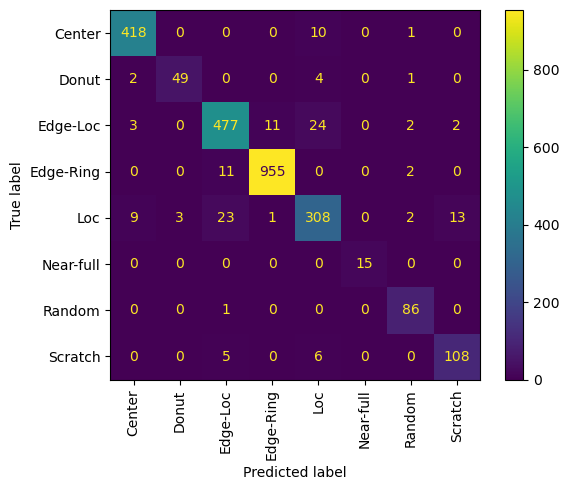

誤分類されたデータ:
                                                waferMap  dieSize   lotName  \
13214  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1080.0  lot23498   
19017  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1129.0  lot42616   
13391  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...    935.0  lot23839   
24617  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2,...    562.0  lot46963   
22429  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...   1109.0  lot45540   
...                                                  ...      ...       ...   
18881  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1198.0  lot42391   
20038  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   1256.0  lot43778   
10652  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  12662.0  lot19842   
22852  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2,...    904.0  lot45634   
17671  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...    776.0  lot40792   

       waferIndex failureType  
13214   

In [5]:
%%timeit -r 1 -n 1

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# データのインポート
df=pd.read_pickle("../input/LSWMD_25519.pkl")

# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.10, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution(x_test_df, train_df)

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = (matching_rows/(len(y_test_df_by_failure_type)))
    
    average_accuracy = sum(accuracies.values())/len(accuracies)

print(f"平均精度：{average_accuracy*100:.2f}%")

# Confusion Matrixを計算
cm = confusion_matrix(y_test_df, user_result_df, labels=df['failureType'].unique())

# Confusion Matrixを可視化
ConfusionMatrixDisplay.from_predictions(y_test_df, user_result_df, xticks_rotation="vertical")
plt.show()

# 誤分類されたデータの抽出
misclassified_indices = y_test_df.index[y_test_df['failureType'] != user_result_df['failureType']]
misclassified_data = test_df.loc[misclassified_indices]

# 誤分類されたデータを表示
print("誤分類されたデータ:")
print(misclassified_data)
#for map in misclassified_data['waferMap']:
#    print(map.shape)
#    show_img(map)

